# YouTube Trends Scraper & Content Generator

A simple workflow to extract trending videos from YouTube and analyze them for potential content opportunities.

## Import Required Libraries

In [1]:
import os
import requests
from bs4 import BeautifulSoup
from dataclasses import dataclass
from IPython.display import display, Image
from typing import List, TypedDict, Optional
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv
from datetime import datetime

## Load Environment Variables

In [2]:
# Load environment variables
load_dotenv()

# Set Google API key for future use
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

## Define Data Models

In [3]:
@dataclass
class TrendingVideo:
    """Data model for a trending video."""

    title: str
    channel: str
    thumbnail_url: str
    video_url: str
    rank: int


class WorkflowState(TypedDict):
    """State schema for the trending videos workflow."""

    # Input
    url: str
    # Extraction Results
    raw_html: Optional[str]
    trending_videos: List[TrendingVideo]
    # Status
    error: Optional[str]
    timestamp: Optional[str]

## Define Workflow Nodes

In [ ]:
def fetch_page_node(state: WorkflowState) -> dict:
    """Fetch the HTML content from YouTube Trends24."""
    try:
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }

        response = requests.get(state["url"], headers=headers, timeout=10)
        response.raise_for_status()

        return {"raw_html": response.text, "timestamp": datetime.now().isoformat()}

    except Exception as e:
        return {
            "error": f"Failed to fetch page: {str(e)}",
            "timestamp": datetime.now().isoformat(),
        }


def extract_videos_node(state: WorkflowState) -> dict:
    """Extract trending videos from the HTML content specifically from the 'All' section."""
    if state.get("error"):
        return {"trending_videos": []}

    try:
        soup = BeautifulSoup(state["raw_html"], "html.parser")
        videos = []

        # Find the "All" section by looking for h3 with id="group-all"
        all_header = soup.find("h3", id="group-all")
        if not all_header:
            return {
                "error": "Could not find the 'All' section header",
                "trending_videos": [],
            }

        # Find the parent section containing this header
        all_section = all_header.find_parent("section", class_="page-section")
        if not all_section:
            return {
                "error": "Could not find the 'All' section container",
                "trending_videos": [],
            }

        # Find the video list within this specific section
        video_list = all_section.find(
            "ol", {"aria-labelledby": "group-all", "class": "video-list"}
        )
        if not video_list:
            return {
                "error": "Could not find video list in 'All' section",
                "trending_videos": [],
            }

        # Find all video items
        video_items = video_list.find_all("li", class_="video-item")

        for item in video_items[:20]:  # Top 20 videos
            try:
                # Extract rank from the span
                rank_span = item.find(
                    "span", class_=["text-slate-400", "font-semibold", "text-xl", "p-4"]
                )
                rank = (
                    int(rank_span.get_text(strip=True))
                    if rank_span
                    else len(videos) + 1
                )

                # Extract video link
                video_link = item.find("a", class_="video-link")
                if not video_link:
                    continue

                video_url = video_link.get("href", "")

                # Extract thumbnail
                thumbnail_img = video_link.find("img", class_="thumbnail")
                thumbnail_url = thumbnail_img.get("src", "") if thumbnail_img else ""

                # Extract title
                title_elem = video_link.find("h4", class_="vc-title")
                title = title_elem.get_text(strip=True) if title_elem else "No title"

                # Extract channel and publication info
                channel = ""
                info_p = video_link.find("p", class_=["text-sm", "text-slate-500"])
                if info_p:
                    # Extract channel from the "by <channel>" pattern
                    channel_spans = info_p.find_all("span", class_="font-medium")
                    if len(channel_spans) >= 2:
                        # The second span should be the channel name
                        channel = channel_spans[1].get_text(strip=True)

                # Create video object
                video = TrendingVideo(
                    title=title,
                    channel=channel,
                    thumbnail_url=thumbnail_url,
                    video_url=video_url,
                    rank=rank,
                )

                videos.append(video)

            except Exception as e:
                print(f"Error extracting video {rank}: {e}")
                continue

        return {"trending_videos": videos}

    except Exception as e:
        return {"error": f"Failed to extract videos: {str(e)}", "trending_videos": []}

## Build the Workflow

In [5]:
# Create the workflow
workflow = StateGraph(WorkflowState)

# Add nodes
workflow.add_node("fetch_page", fetch_page_node)
workflow.add_node("extract_videos", extract_videos_node)

# Add edges
workflow.add_edge(START, "fetch_page")
workflow.add_edge("fetch_page", "extract_videos")
workflow.add_edge("extract_videos", END)

# Compile the workflow
app = workflow.compile()

# Visualize the Workflow

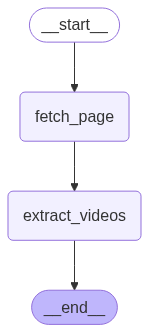

In [20]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


## Test the Workflow

In [8]:
initial_state = {
    "url": "https://youtube.trends24.in/",
    "raw_html": None,
    "trending_videos": [],
    "error": None,
    "timestamp": None,
}

result = app.invoke(initial_state)

print(f"Extraction completed at: {result.get('timestamp')}")
print(f"Error: {result.get('error', 'None')}")
print(f"Number of videos extracted: {len(result.get('trending_videos', []))}")
print("\n" + "=" * 50)
print("TOP 10 TRENDING VIDEOS")
print("=" * 50)

for video in result.get("trending_videos", []):
    print(f"{video.rank}. {video.title}")
    if video.video_url:
        print(f"   URL: {video.video_url}")
    print()

Extraction completed at: 2025-06-30T21:06:50.499310
Error: None
Number of videos extracted: 20

TOP 10 TRENDING VIDEOS
1. Ilia Topuria Knocks Out Charles Oliveira 👊 | UFC 317
   URL: https://youtube.com/watch?v=kpnoibF4eNg

2. 1 Conservative vs 20 Feminists (Ft. Candace Owens)
   URL: https://youtube.com/watch?v=UyzbSeVBxvk

3. I Cooked EVERY Animal’s Brisket
   URL: https://youtube.com/watch?v=iJhQkwKjdTk

4. I Bought the Cheapest Rolls Royce to Cummins Swap
   URL: https://youtube.com/watch?v=0aQs685Nfuk

5. PREGNANCY RUMOR In The GROUP CHAT
   URL: https://youtube.com/watch?v=e0lAs47C8yE

6. Ilia Topuria shoves Paddy Pimblett after calling him out at #UFC317 | ESPN MMA
   URL: https://youtube.com/watch?v=tfyJS56SZbM

7. $1 vs $10,000,000 Gym!
   URL: https://youtube.com/watch?v=WzWg3W9EwTs

8. How Much Weight Can I Gain in World's Most Obese Town?
   URL: https://youtube.com/watch?v=mBSPJ_QeUxY

9. HELLUVA SHORTS 5 // MISSION: ORPHAN TIME // HELLUVA BOSS
   URL: https://youtube.com/